<a href="https://colab.research.google.com/github/RodrigoOBC/Notebooks_RedesNeurais/blob/main/Classificacao_de_Peixes_com_Resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
import seaborn as sns
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.callbacks import *
from tensorflow.keras import layers, models, metrics
from tensorflow.keras.applications.efficientnet import *
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tensorflow.keras.applications.resnet50 import ResNet50
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
import cv2
from glob import glob
from random import shuffle
import tensorflow as tf 
import numpy as np
import pandas as pd
from pathlib import Path
import os.path

2021-09-15 04:02:38.422603: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [ ]:
image_dir = Path('../input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset')
paths = list(image_dir.glob(r'**/*.png'))
paths_bom = []
for path_bom in paths:
    if 'GT' not in str(path_bom):
        paths_bom.append(path_bom)

In [ ]:
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], paths_bom))
paths = pd.Series(paths_bom, name='path').astype(str)
labels = pd.Series(labels, name='Label')

In [ ]:
image_df = pd.concat([paths, labels], axis=1)

In [ ]:
image_df.head()

,path,Label
0,../input/a-large-scale-fish-dataset/Fish_Datas...,Hourse Mackerel
1,../input/a-large-scale-fish-dataset/Fish_Datas...,Hourse Mackerel
2,../input/a-large-scale-fish-dataset/Fish_Datas...,Hourse Mackerel
3,../input/a-large-scale-fish-dataset/Fish_Datas...,Hourse Mackerel
4,../input/a-large-scale-fish-dataset/Fish_Datas...,Hourse Mackerel


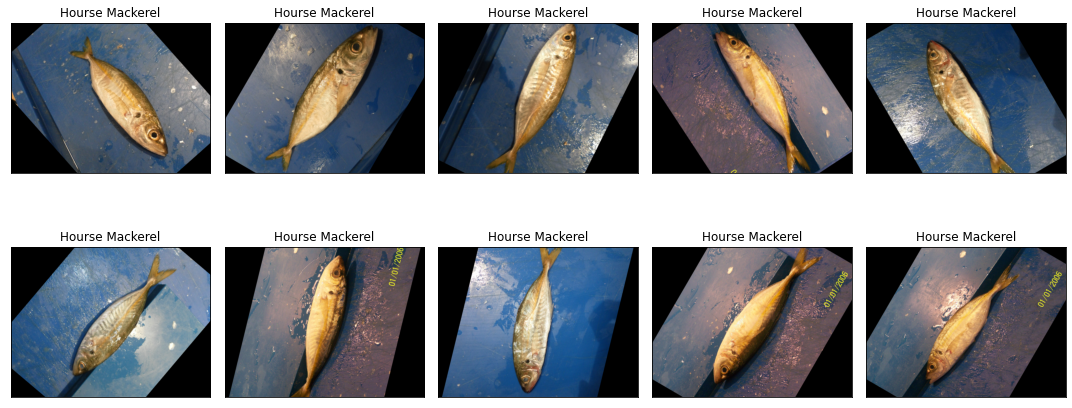

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.path[i]))
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()

In [ ]:
train_df, test_df = train_test_split(image_df, train_size=0.9, shuffle=True, random_state=1)

In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [ ]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='path',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 6480 validated image filenames belonging to 9 classes.
Found 1620 validated image filenames belonging to 9 classes.
Found 900 validated image filenames belonging to 9 classes.


In [ ]:
def build_model():
    model= models.Sequential()
    model.add(ResNet50(input_shape=(224,224,3), include_top=False, weights='imagenet'))
    model.add(Flatten(name='flatten'))
    model.add(Dense(2024, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(9, activation='sigmoid'))
    #model = Model(inputs=input_img, outputs=x)
    return model

In [ ]:
Resnet = build_model()
Resnet.summary()

2021-09-15 04:02:52.381428: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-15 04:02:52.383981: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-09-15 04:02:52.421725: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-15 04:02:52.422336: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-09-15 04:02:52.422411: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-09-15 04:02:52.447480: I tensorflow/stream_executor/platform/def

94773248/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 2024)              203114472 
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2073600   
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________

In [ ]:
estop = EarlyStopping(monitor='loss', mode='min', patience=25)
opt = Adam(lr=0.001)
Resnet.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])

In [ ]:
print("run fit generator")
fit_history  = Resnet.fit_generator(train_images,epochs=100, steps_per_epoch=32,
                    validation_data=val_images, validation_steps=32, 
                    callbacks=[estop])

run fit generator


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2021-09-15 04:02:58.290387: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-09-15 04:02:58.294420: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000185000 Hz


Epoch 1/100


2021-09-15 04:03:03.165333: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-09-15 04:03:03.991374: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-09-15 04:03:04.326394: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


32/32 [==============================] - 55s 1s/step - loss: 5.0435 - accuracy: 0.1035 - val_loss: 3814.9971 - val_accuracy: 0.1094
Epoch 2/100
32/32 [==============================] - 36s 1s/step - loss: 1.8778 - accuracy: 0.3467 - val_loss: 788.0056 - val_accuracy: 0.1201
Epoch 3/100
32/32 [==============================] - 32s 1s/step - loss: 1.7960 - accuracy: 0.3622 - val_loss: 28.7260 - val_accuracy: 0.1045
Epoch 4/100
32/32 [==============================] - 30s 935ms/step - loss: 1.6708 - accuracy: 0.4143 - val_loss: 39.9941 - val_accuracy: 0.1074
Epoch 5/100
32/32 [==============================] - 29s 914ms/step - loss: 1.6318 - accuracy: 0.3921 - val_loss: 2.3649 - val_accuracy: 0.1016
Epoch 6/100
32/32 [==============================] - 29s 891ms/step - loss: 1.6369 - accuracy: 0.3868 - val_loss: 2.1986 - val_accuracy: 0.1133
Epoch 7/100
32/32 [==============================] - 28s 867ms/step - loss: 1.4185 - accuracy: 0.4871 - val_loss: 2.2033 - val_accuracy: 0.1172
Epoch 

In [ ]:
print(fit_history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


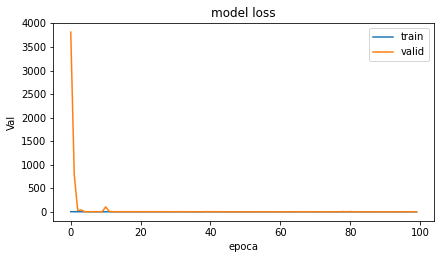

In [ ]:
 plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(fit_history.history['loss'])  
plt.plot(fit_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('Val')  
plt.xlabel('epoca')  
plt.legend(['train', 'valid']) ;

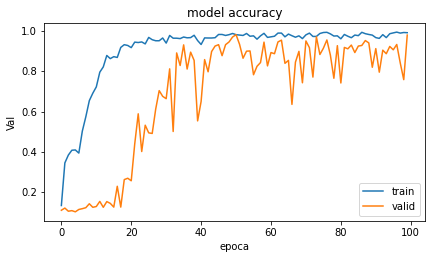

In [ ]:
 plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(fit_history.history['accuracy'])  
plt.plot(fit_history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('Val')  
plt.xlabel('epoca')  
plt.legend(['train', 'valid']) ;

In [ ]:
pred = Resnet.predict(test_images)
pred=np.argmax(pred,axis=1)

In [ ]:
pred_df=test_df.copy()
labels={}
for l,v in test_images.class_indices.items():
    labels.update({v:l})
pred_df['pred']=pred
pred_df['pred']=pred_df['pred'].apply(lambda x: labels[x])

Accuracy Score: 0.9588888888888889


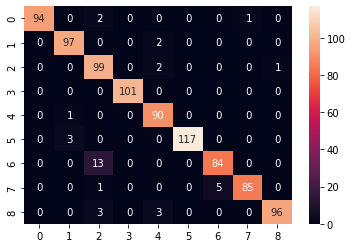

In [ ]:

print(f"Accuracy Score: {accuracy_score(pred_df['Label'],pred_df['pred'])}")
sns.heatmap(confusion_matrix(pred_df['Label'],pred_df['pred']), annot=True, fmt='2d');